In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from keras.applications import VGG16
import keras
import boto3
import botocore
import os
import pickle
from matplotlib import pyplot as plt
%matplotlib inline
import errno


Using TensorFlow backend.


In [5]:
zap = pd.read_csv('./zap.csv')

In [3]:
brand_dict = dict(zip(zap.brand_name.unique(),range(0,len(zap.brand_name.unique()))))
shoe_dict = dict(zip(zap.shoe_name.unique(),range(0,len(zap.shoe_name.unique()))))
color_dict = dict(zip(zap.colorway,zap.colorcode))

In [5]:
zap.shape

(26422, 10)

In [3]:
loaded_data=pickle.load(open('./lateralfrontleft/0_0_401833'))

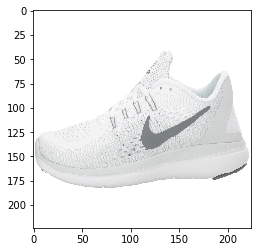

In [4]:
plt.imshow(loaded_data)

In [6]:
def get_shoe(shoe_dict,view,s3,BUCKET_NAME='capstoneshoes'):
    KEY = '{}/{}'.format(shoe_dict,view)
    try:
        s3.Bucket(BUCKET_NAME).download_file(KEY, '{}/{}'.format(view,shoe_dict))
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            print("The object does not exist.")
        else:
            raise

In [7]:
def get_data(row,s3):
    views = ['lateralfrontleft','heelview','toeview','medialfrontright','topview']
    shoe_dict = row[1]['shoe_hash']
    print shoe_dict
    try:
        for view in views:
            path = os.makedirs('{}'.format(view))
            #row_imgs = map(lambda shoe_dict: get_shoe(shoe_dict), row[views].tolist())
            get_shoe(shoe_dict,view,s3)
    except OSError:
        for view in views:
            path = os.walk('{}'.format(view))
            #row_imgs = map(lambda shoe_dict: get_shoe(shoe_dict), row[views].tolist())
            get_shoe(shoe_dict,view,s3)
    except:    
        pass

In [8]:
s3 = boto3.resource('s3')
def bucket_connect(x):
    return get_data(x,s3)

In [9]:
import multiprocessing
from multiprocessing.pool import Pool

In [10]:
pool = Pool(processes=multiprocessing.cpu_count())

In [ ]:
pool.map(bucket_connect, list(zap.iterrows()))

0_3015_676144
5_2560_661816
15_3016_658236
0_128_676618
5_3056_664543
4_3859_701041
0_3017_55378
8_524_667865


In [27]:
def retrieve(directory):
    file_list = []
    for subdir, dirs, files in os.walk('./{}'.format(directory)):
        for f in files:
            if f != '.DS_Store':
                file_list.append(f)
        return file_list


In [86]:
sample = retrieve('lateralfrontleft')

In [87]:
len(sample)

6753

In [83]:
def open_array(directory):
    file_list = retrieve(directory)
    array_list = []
    for f in file_list:
        loaded_data=pickle.load(open('./{}/{}'.format(directory,f)))
        array_list.append(loaded_data)
    return dict(zip(file_list, array_list))

In [88]:
test = open_array('lateralfrontleft')

In [152]:
test

{'55_3098_273286': array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ..., 
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ..., 
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ..., 
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ..., 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ..., 
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ..., 
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ..., 
     

In [89]:
len(test)

6753

In [123]:
test_sample = np.array([key for key in test])

In [124]:
test_sample

array(['55_3098_273286', '7_134_1522', '25_1485_1985', ..., '3_1756_4564',
       '14_1119_488326', '8_444_685262'],
      dtype='|S14')

In [150]:
test_sample.sample

AttributeError: 'numpy.ndarray' object has no attribute 'sample'

In [135]:
no_brand = zap.drop('brand_name',axis=1)

In [138]:
X = no_brand.values
y = zap.brand_name.values
skf = StratifiedKFold(n_splits=3)


In [139]:
print skf

StratifiedKFold(n_splits=3, random_state=None, shuffle=False)


In [140]:
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

('TRAIN:', array([ 2713,  2716,  2868, ..., 26419, 26420, 26421]), 'TEST:', array([    0,     1,     2, ..., 17268, 17277, 17305]))
('TRAIN:', array([    0,     1,     2, ..., 26419, 26420, 26421]), 'TEST:', array([ 2713,  2716,  2868, ..., 23732, 24232, 25121]))
('TRAIN:', array([    0,     1,     2, ..., 23732, 24232, 25121]), 'TEST:', array([ 4581,  4583,  4586, ..., 26419, 26420, 26421]))


In [146]:
X_train[0][-1]

'0_0_684832'

In [10]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
import numpy as np

#Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
model_vgg16_conv.summary()

#Create your own input format (here 3x200x200)
input = Input(shape=(224,224,3),name = 'image_input')

#Use the generated model 
output_vgg16_conv = model_vgg16_conv(input)

#Add the fully-connected layers 
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(8, activation='softmax', name='predictions')(x)

#Create your own model 
my_model = Model(input=input, output=x)

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
my_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("im...)`


In [26]:
features_for_train_data = my_model.predict(X_train)
features_for_test_data = my_model.predict(X_val)
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
my_model.compile(optimizer=adam,
              loss='mse',
              metrics=['accuracy'])

my_model.fit(features_for_train_data, y_train,
          nb_epoch=80,
          batch_size=32,
          validation_data=(features_for_test_data, y_val))

ValueError: Error when checking : expected input_9 to have 4 dimensions, but got array with shape (17700, 9)

In [20]:
# Generate a model with all layers (with top)
vgg16 = VGG16(weights=None, include_top=True)

#Add a layer where input is the output of the  second last layer 
x = Dense(8, activation='softmax', name='predictions')(vgg16.layers[-2].output)

#Then create the corresponding model 
my_model = Model(input=vgg16.input, output=x)
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("in...)`
